In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
from bs4 import BeautifulSoup

warnings.filterwarnings('ignore')

In [61]:
train_df = pd.read_csv('data/train.csv')

In [62]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [63]:
train_df.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate
399496,399496,281001,532772,What is a true purpose of life? Why are we her...,Why did life evoke on earth and what is its pu...,0
143381,143381,72940,227179,Which is better as a career: physiotherapy or ...,"As a career option, which one is better: physi...",1
126002,126002,16685,47340,What are your favorite books?,What are your favourite books?,1
159443,159443,248897,248898,What are some examples of adaptive radiation?,What is adaptive radiation? What are some exam...,1
361701,361701,17167,491569,Does pulled out hair grow back?,Why do I have the urge to pull out my hair?,0


In [64]:
train_df.shape

(404290, 6)

In [65]:
train_df.duplicated().sum()

np.int64(0)

In [66]:
train_df.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [67]:
train_df.dropna(axis=0, inplace=True)

In [68]:
train_df.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate
34944,34944,63938,63939,I work my whole body out every 2 days. Due to ...,I'm addicted to working out is this normal I f...,0
151705,151705,238478,238479,If I got 2As 2A*s 2bs and 2 cs in gcse is it g...,My preparation for the IIT 2016 is mid between...,0
277212,277212,283389,396278,It's possible to search questions inside a topic?,"How do you search for questions from several ""...",1
199386,199386,96540,300868,What is the best way to learn Japanese by your...,What are the best ways to learn Japanese witho...,0
217309,217309,323630,323631,What strikes first time visitors as special or...,What strikes first time visitors as special or...,0


In [69]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 404287 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404287 non-null  int64 
 1   qid1          404287 non-null  int64 
 2   qid2          404287 non-null  int64 
 3   question1     404287 non-null  object
 4   question2     404287 non-null  object
 5   is_duplicate  404287 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 21.6+ MB


is_duplicate
0    255024
1    149263
Name: count, dtype: int64


<Axes: xlabel='is_duplicate'>

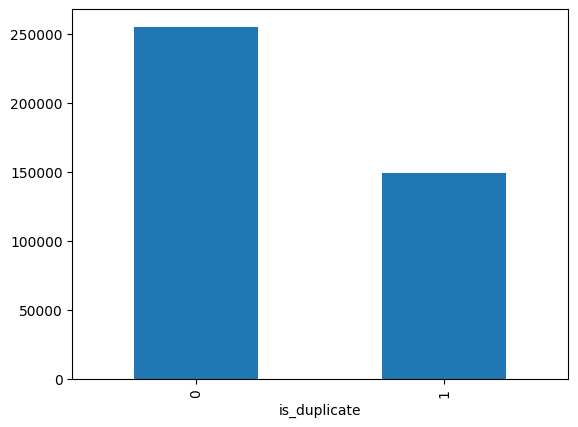

In [70]:
print(train_df['is_duplicate'].value_counts())
train_df['is_duplicate'].value_counts().plot(kind='bar')

In [71]:
qid = pd.Series(train_df['qid1'].to_list() + train_df['qid2'].to_list())
print('Number of total unique questions: ', np.unique(qid).shape[0])
x = qid.value_counts() > 1
print('Number of duplicated questions: ', x[x].shape[0])

Number of total unique questions:  537929
Number of duplicated questions:  111778


Text(0, 0.5, 'Number of questions')

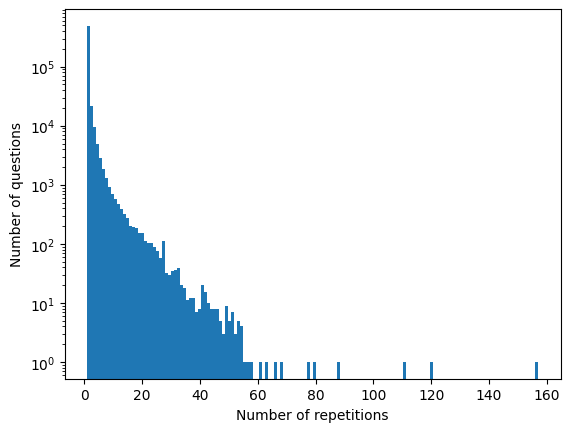

In [72]:
plt.hist(qid.value_counts(), bins=150)
plt.yscale('log')
plt.xlabel('Number of repetitions')
plt.ylabel('Number of questions')

In [73]:
df = train_df.sample(40000, random_state=42)
df.shape

(40000, 6)

In [74]:
(df['is_duplicate'].value_counts()/df['is_duplicate'].count())*100

is_duplicate
0    62.8575
1    37.1425
Name: count, dtype: float64

In [75]:
def preprocess(q):

    # convert to lowercase
    q = q.strip().lower()

    # replace special characters with their names
    q = q.replace("%", " percent")
    q = q.replace("$", " dollar ")
    q = q.replace('₹', " rupee ")
    q = q.replace('€', " euro ")
    q = q.replace("@", " at " )


    # replace [math] with nothing
    q = q.replace('[math]', '')


    # replace large numbers with string equivalents
    q = q.replace(" ,000", "k ")
    q = q.replace(" ,000,000", "m ")
    q = q.replace(" ,000,000,000", "b ")
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)


    # remove HTML tags
    q = re.sub(r'<[^>]+>', '', q)


    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953

    contractions = { 
        "ain't": "am not",
        "aren't": "are not",
        "can't": "can not",
        "can't've": "can not have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would",
        "he'd've": "he would have",
        "he'll": "he will",
        "he'll've": "he will have",
        "he's": "he is",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how is",
        "i'd": "i would",
        "i'd've": "i would have",
        "i'll": "i will",
        "i'll've": "i will have",
        "i'm": "i am",
        "i've": "i have",
        "isn't": "is not",
        "it'd": "it would",
        "it'd've": "it would have",
        "it'll": "it will",
        "it'll've": "it will have",
        "it's": "it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she would",
        "she'd've": "she would have",
        "she'll": "she will",
        "she'll've": "she will have",
        "she's": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so as",
        "that'd": "that would",
        "that'd've": "that would have",
        "that's": "that is",
        "there'd": "there would",
        "there'd've": "there would have",
        "there's": "there is",
        "they'd": "they would",
        "they'd've": "they would have",
        "they'll": "they will",
        "they'll've": "they will have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "wasn't": "was not",
        "we'd": "we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what will",
        "what'll've": "what will have",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "when's": "when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where is",
        "where've": "where have",
        "who'll": "who will",
        "who'll've": "who will have",
        "who's": "who is",
        "who've": "who have",
        "why's": "why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you would",
        "you'd've": "you would have",
        "you'll": "you will",
        "you'll've": "you will have",
        "you're": "you are",
        "you've": "you have"
        }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]
        
        q_decontracted.append(word)


    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")

    # remove punctuation
    q = re.sub(r'[^\w\s]', '', q)

    return q

In [76]:
preprocess("<h1>how are you've not called since! morning</h1>")

'how are you have not called since morning'

In [77]:
df['question1'] = df['question1'].apply(preprocess)
df['question2'] = df['question2'].apply(preprocess)

In [78]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
8067,8067,15738,15739,how do i play pokémon go in korea,how do i play pokémon go in china,0
224279,224279,332326,332327,will a breathing treatment help a cough,how can i help someone that is unconscious but...,0
252452,252452,336023,366789,is kellyanne conway annoying in your opinion,did kellyanne conway really imply that we shou...,0
174039,174039,268330,268331,how do you rate 110 and review maruti baleno,what career options does one have after comple...,0
384863,384863,28901,233483,what are some good books on marketing,what are some of the best books ever written a...,1


1. Token Features
- **cwc_min:** Ratio of number of common words to the length of the smaller question.
- **cwc_max:** Ratio of number of common words to the length of the longer question.
- **csc_min:** Ratio of number of common stop words to the length of the smaller question.
- **csc_max:** Ratio of number of common stop words to the length of the larger question question.
- **ctc_min:** Ratio of number of common tokens to the length of the smaller question.
- **ctc_min:** Ratio of number of common tokens to the length of the larger question.
- **last_word_eq:** 1 id the last word of both sentences is the same. 0 otherwise.
- **first_word_eq:** 1 id the first word of both sentences is the same. 0 otherwise.

In [79]:
from nltk.corpus import stopwords


def get_token_features(row):

    q1 = row['question1']
    q2 = row['question2']

    SAFE_DIV = 0.0001

    token_features = [0.0]*8

    # get tokens in both questions
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    STOP_WORDS = stopwords.words('english')

    # get stopwords in both questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])

    # get ordinary words (non-stopwords) in both questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

    # number of common tokens in both questions
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

    # number of common stop words in both tokens
    common_stopword_count = len(q1_stops.intersection(q2_stops))

    # number of common words in both tokens
    common_word_count = len(q1_words.intersection(q2_words))

    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count/ (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stopword_count/ (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stopword_count/ (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count/ (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count/ (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[6] = 1 if (q1_tokens[-1] == q2_tokens[-1]) else 0
    token_features[7] = 1 if (q1_tokens[0] == q2_tokens[0]) else 0


    return token_features


In [80]:
token_features = df.apply(get_token_features, axis=1)

In [81]:
df['cwc_min'] = list(map(lambda x: x[0], token_features))
df['cwc_max'] = list(map(lambda x: x[1], token_features))
df['csc_min'] = list(map(lambda x: x[2], token_features))
df['csc_max'] = list(map(lambda x: x[3], token_features))
df['ctc_min'] = list(map(lambda x: x[4], token_features))
df['ctc_max'] = list(map(lambda x: x[5], token_features))
df['last_word_eq'] = list(map(lambda x: x[6], token_features))
df['first_word_eq'] = list(map(lambda x: x[7], token_features))

2. Length Features
- **mean_len:** Average token length of both questions
- **abs_len_diff:** Absolute difference in token lengths of both questions
- **longest_substr_ratio:** Ratio of longest common substring in both questions to the token length of smaller question

In [82]:
import distance

# q1 = "how do i play pokémon go in korea"
# q2 = "how do i play pokémon go in china"

def get_length_features(row):

    q1 = row['question1']
    q2 = row['question2']

    q1_tokens = q1.split()
    q2_tokens = q2.split()

    length_features = [0.0]*3

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features

    # mean token length
    length_features[0] = (len(q1_tokens) + len(q2_tokens))/2

    # absolute difference in length
    length_features[1] = abs(len(q1_tokens) - len(q2_tokens))

    # longest substring ratio
    substrs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(substrs[0]) / ( min(len(q1), len(q2)) + 1)
        
    return length_features


In [83]:
length_features = df.apply(get_length_features, axis=1)

In [84]:
df['mean_len'] = list(map(lambda x: x[0], length_features))
df['abs_len_diff'] = list(map(lambda x: x[1], length_features))
df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

3. Fuzzy Features

In [85]:
from fuzzywuzzy import fuzz

def get_fuzzy_features(row):

    q1 = row['question1']
    q2 = row['question2']

    fuzzy_features = [0.0]*4

    fuzzy_features[0] = fuzz.ratio(q1, q2)
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features



In [86]:
fuzzy_features = df.apply(get_fuzzy_features, axis=1)

In [87]:
df['fuzzy_ratio'] = list(map(lambda x: x[0] , fuzzy_features))
df['fuzzy_partial_ratio'] = list(map(lambda x: x[1] , fuzzy_features))
df['token_order_ratio'] = list(map(lambda x: x[2] , fuzzy_features))
df['token_set_ratio'] = list(map(lambda x: x[3] , fuzzy_features))

In [88]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,mean_len,abs_len_diff,longest_substr_ratio,fuzzy_ratio,fuzzy_partial_ratio,token_order_ratio,token_set_ratio
8067,8067,15738,15739,how do i play pokémon go in korea,how do i play pokémon go in china,0,0.749981,0.749981,0.999975,0.999975,...,0.874989,0,1,8.0,0,0.823529,88,88,81,90
224279,224279,332326,332327,will a breathing treatment help a cough,how can i help someone that is unconscious but...,0,0.499988,0.399992,0.000000,0.000000,...,0.181817,0,0,9.0,4,0.250000,28,49,48,55
252452,252452,336023,366789,is kellyanne conway annoying in your opinion,did kellyanne conway really imply that we shou...,0,0.499988,0.181817,0.000000,0.000000,...,0.095238,0,0,14.0,14,0.400000,34,57,38,53
174039,174039,268330,268331,how do you rate 110 and review maruti baleno,what career options does one have after comple...,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0,0,14.5,11,0.066667,22,41,32,34
384863,384863,28901,233483,what are some good books on marketing,what are some of the best books ever written a...,1,0.666644,0.399992,0.749981,0.499992,...,0.454541,1,1,9.0,4,0.368421,68,62,66,88


In [89]:
df['q1_len'] = df['question1'].str.len()
df['q2_len'] = df['question2'].str.len()

In [90]:
df['q1_num_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_num_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

In [91]:

def total_words(row): 
    w1 = set(map(lambda word: word.lower().strip() ,row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip() ,row['question2'].split(" ")))

    return len(w1) + len(w2)

In [92]:
df['words_total'] = df.apply(total_words, axis=1)

In [93]:
def common_words(row): 
    w1 = set(map(lambda word: word.lower().strip() ,row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip() ,row['question2'].split(" ")))

    return len(w1 & w2)

In [94]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,longest_substr_ratio,fuzzy_ratio,fuzzy_partial_ratio,token_order_ratio,token_set_ratio,q1_len,q2_len,q1_num_words,q2_num_words,words_total
8067,8067,15738,15739,how do i play pokémon go in korea,how do i play pokémon go in china,0,0.749981,0.749981,0.999975,0.999975,...,0.823529,88,88,81,90,33,33,8,8,16
224279,224279,332326,332327,will a breathing treatment help a cough,how can i help someone that is unconscious but...,0,0.499988,0.399992,0.000000,0.000000,...,0.250000,28,49,48,55,39,62,7,11,17
252452,252452,336023,366789,is kellyanne conway annoying in your opinion,did kellyanne conway really imply that we shou...,0,0.499988,0.181817,0.000000,0.000000,...,0.400000,34,57,38,53,44,116,7,21,27
174039,174039,268330,268331,how do you rate 110 and review maruti baleno,what career options does one have after comple...,0,0.000000,0.000000,0.000000,0.000000,...,0.066667,22,41,32,34,44,123,9,20,27
384863,384863,28901,233483,what are some good books on marketing,what are some of the best books ever written a...,1,0.666644,0.399992,0.749981,0.499992,...,0.368421,68,62,66,88,37,60,7,11,18


In [95]:
df['words_common'] = df.apply(common_words, axis=1)

In [96]:
df['words_shared']= df['words_common']/df['words_total']

In [97]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,fuzzy_partial_ratio,token_order_ratio,token_set_ratio,q1_len,q2_len,q1_num_words,q2_num_words,words_total,words_common,words_shared
8067,8067,15738,15739,how do i play pokémon go in korea,how do i play pokémon go in china,0,0.749981,0.749981,0.999975,0.999975,...,88,81,90,33,33,8,8,16,7,0.437500
224279,224279,332326,332327,will a breathing treatment help a cough,how can i help someone that is unconscious but...,0,0.499988,0.399992,0.000000,0.000000,...,49,48,55,39,62,7,11,17,2,0.117647
252452,252452,336023,366789,is kellyanne conway annoying in your opinion,did kellyanne conway really imply that we shou...,0,0.499988,0.181817,0.000000,0.000000,...,57,38,53,44,116,7,21,27,2,0.074074
174039,174039,268330,268331,how do you rate 110 and review maruti baleno,what career options does one have after comple...,0,0.000000,0.000000,0.000000,0.000000,...,41,32,34,44,123,9,20,27,0,0.000000
384863,384863,28901,233483,what are some good books on marketing,what are some of the best books ever written a...,1,0.666644,0.399992,0.749981,0.499992,...,62,66,88,37,60,7,11,18,5,0.277778


In [98]:
df.shape

(40000, 28)

In [99]:
ques_df = df[['question1', 'question2']]
print(ques_df.shape)
ques_df.head()

(40000, 2)


,question1,question2
8067,how do i play pokémon go in korea,how do i play pokémon go in china
224279,will a breathing treatment help a cough,how can i help someone that is unconscious but...
252452,is kellyanne conway annoying in your opinion,did kellyanne conway really imply that we shou...
174039,how do you rate 110 and review maruti baleno,what career options does one have after comple...
384863,what are some good books on marketing,what are some of the best books ever written a...


In [100]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features=3000)
questions = df['question1'].to_list() + df['question2'].to_list()
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(), 2)
print(q1_arr.shape, q2_arr.shape)

(40000, 3000) (40000, 3000)


In [101]:
q1_df = pd.DataFrame(q1_arr, index=ques_df.index)
q2_df = pd.DataFrame(q2_arr, index=ques_df.index)
temp_df = pd.concat([q1_df, q2_df], axis=1)
print(temp_df.shape)
temp_df.head()

(40000, 6000)


,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
8067,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
224279,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
252452,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
174039,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
384863,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [102]:
df_ = df.drop(columns=['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'])

print(df_.shape)
df_

(40000, 22)


,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,mean_len,abs_len_diff,...,fuzzy_partial_ratio,token_order_ratio,token_set_ratio,q1_len,q2_len,q1_num_words,q2_num_words,words_total,words_common,words_shared
8067,0.749981,0.749981,0.999975,0.999975,0.874989,0.874989,0,1,8.0,0,...,88,81,90,33,33,8,8,16,7,0.437500
224279,0.499988,0.399992,0.000000,0.000000,0.285710,0.181817,0,0,9.0,4,...,49,48,55,39,62,7,11,17,2,0.117647
252452,0.499988,0.181817,0.000000,0.000000,0.285710,0.095238,0,0,14.0,14,...,57,38,53,44,116,7,21,27,2,0.074074
174039,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,14.5,11,...,41,32,34,44,123,9,20,27,0,0.000000
384863,0.666644,0.399992,0.749981,0.499992,0.714276,0.454541,1,1,9.0,4,...,62,66,88,37,60,7,11,18,5,0.277778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186413,0.799984,0.666656,0.999967,0.999967,0.874989,0.777769,0,1,8.5,1,...,83,70,88,51,41,9,8,17,7,0.411765
369320,0.799984,0.666656,0.499975,0.249994,0.714276,0.499995,0,0,8.5,3,...,76,66,85,60,46,10,7,17,5,0.294118
205738,0.599988,0.499992,0.499988,0.249997,0.555549,0.333331,1,0,12.0,6,...,77,57,70,69,43,15,9,23,5,0.217391
386258,0.999950,0.666644,0.749981,0.599988,0.833319,0.624992,0,1,7.0,2,...,91,75,95,22,31,6,8,14,5,0.357143


In [103]:
temp_df['is_duplicate'] = df['is_duplicate']
print(temp_df.shape)
temp_df.head()

(40000, 6001)


,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,is_duplicate
8067,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
224279,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
252452,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
174039,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
384863,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [104]:
final_df = pd.concat([df_, temp_df], axis=1)
print(final_df.shape)
final_df.head()

(40000, 6023)


,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,mean_len,abs_len_diff,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,is_duplicate
8067,0.749981,0.749981,0.999975,0.999975,0.874989,0.874989,0,1,8.0,0,...,0,0,0,0,0,0,0,0,0,0
224279,0.499988,0.399992,0.000000,0.000000,0.285710,0.181817,0,0,9.0,4,...,0,0,0,0,0,0,0,0,0,0
252452,0.499988,0.181817,0.000000,0.000000,0.285710,0.095238,0,0,14.0,14,...,0,0,0,0,0,0,0,0,0,0
174039,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,14.5,11,...,0,0,0,0,0,0,0,0,0,0
384863,0.666644,0.399992,0.749981,0.499992,0.714276,0.454541,1,1,9.0,4,...,0,0,0,0,0,0,0,0,0,1


In [105]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(final_df.iloc[:, 0:-1], final_df.iloc[:, -1], test_size=0.2, random_state=42)

In [106]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32000, 6022), (8000, 6022), (32000,), (8000,))

In [107]:
X_train.columns = X_train.columns.astype('str')
# y_train.columns = y_train.columns.astype('str')
X_test.columns = X_test.columns.astype('str')
# y_test.columns = y_test.columns.astype('str')

In [108]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
from sklearn.metrics import accuracy_score
y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred)

0.80325

In [109]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[4288  706]
 [ 868 2138]]
              precision    recall  f1-score   support

           0       0.83      0.86      0.84      4994
           1       0.75      0.71      0.73      3006

    accuracy                           0.80      8000
   macro avg       0.79      0.78      0.79      8000
weighted avg       0.80      0.80      0.80      8000



In [110]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(np.array(X_train), np.array(y_train))
y_pred = xgb.predict(np.array(X_test))
accuracy_score(y_test, y_pred)

0.798125

In [111]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[4184  810]
 [ 805 2201]]
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      4994
           1       0.73      0.73      0.73      3006

    accuracy                           0.80      8000
   macro avg       0.78      0.79      0.78      8000
weighted avg       0.80      0.80      0.80      8000

